# Solutions - Tutorial - Quantum Alternating Operator Ansatz

In [2]:
from qaoa import QAOA
from qaoa.initialstates import InitialState
from qaoa.mixers.base_mixer import Mixer
from qaoa.problems.base_problem import Problem

In [3]:
import sys

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

sys.path.append("../")
from plotroutines import *

In this Exercise Notebook we are going to study the performance fo the QAOA on the maximum cut (MAXCUT) combinatorial optimization problem. The problem can stated as follows:

Consider a graph $G=(V,E)$ with nodes V, where $|V|=n$ and edges E with weights $w_{ij}>0,w_{ij}=w_{ji}$ for $(i,j)\in E$. A cut is defined as a partition of the original set V into two subsets. The cost of a cut is the sum of weights of edges connecting points in the two distinct subsets. MAXCUT seeks to find the cut that maximizes this cost, which can be expressed as:


$C(\vec{x})=\sum_{ij}w_{ij}x_{i}(1-x_{j})$. 

where $x_{i}$ is a binary variable: 0 if the vertex is in the first partition, and 1 if it is in the second partition.


Finding an exact solution for this problem is NP-hard but some classical algorithms can find an approximate solution in polynomial time like the Goemans-Williamson algorithm that guarantees an approximation ratio $\frac{C}{C_{opt}}=0.8785$.

In [60]:
def generate_connected_graph(n, k=3):
    G = nx.barabasi_albert_graph(n, k)
    for edge in G.edges(data=True):
        edge[2]["weight"] = 1.0
    return G

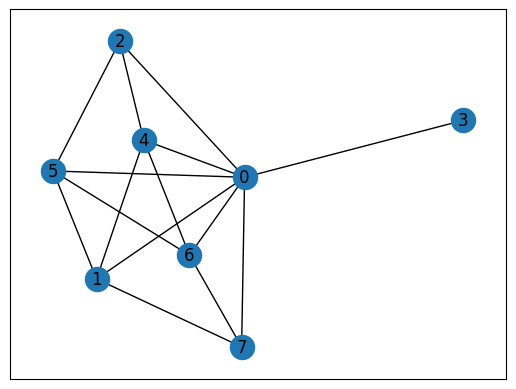

In [61]:
G = generate_connected_graph(8)

pos = nx.spring_layout(G)
nx.draw_networkx(G, pos=pos)

## Exercise: construct a cost function that take in input a string and the graph problem and return the specific cost 

In [6]:
def cost_string(G, string):
    """
    Construct a function that takes in input the problem graph and a string and returns as output the cost function
    associated to that string.
    """

    C = 0
    for edge in G.edges():
        i = int(edge[0])
        j = int(edge[1])
        if string[i] != string[j]:
            w = G[edge[0]][edge[1]]["weight"]
            C += w
    return C

Now we need to map the classical cost function into a Ising Hamiltonian called typically Problem Hamiltonian that encode the cost function in terms of spin variables (qubits). 

To map this classical variable to a quantum representation in terms of spin variables or qubits, we use the transformation:

$x_{i}\rightarrow\frac{1-\sigma^{z}_{i}}{2}$

applying this transfrmation to the cost funciton we obtain the problem Hamiltonian that we were looking for:

$H_{P}=\sum_{ij}\tilde{w_{ij}}\sigma_{i}^{z}\sigma_{j}^{z},\qquad \tilde{w_{ij}}=-\frac{w_{ij}}{4}$




## Define The ZZ circuit using the Qiskit circuit and return the circuit operator to show them that they need that 

In [7]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit import Parameter
from qiskit.quantum_info import Operator


def ZZGate(theta):
    qr = QuantumRegister(2)
    qc = QuantumCircuit(qr)

    """
    Construct the circuit corresponing to the exponential of the ZZ Pauli operator here.
    It should takes in input the parameter and returns as output the circuit implement the exponential.
    """

    qc.cx(qr[0], qr[1])
    qc.rz(theta, qr[1])
    qc.cx(qr[0], qr[1])

    return qc


print(Operator(ZZGate(np.pi / 2)))

Operator([[0.70710678-0.70710678j, 0.        +0.j        ,
           0.        +0.j        , 0.        +0.j        ],
          [0.        +0.j        , 0.70710678+0.70710678j,
           0.        +0.j        , 0.        +0.j        ],
          [0.        +0.j        , 0.        +0.j        ,
           0.70710678+0.70710678j, 0.        +0.j        ],
          [0.        +0.j        , 0.        +0.j        ,
           0.        +0.j        , 0.70710678-0.70710678j]],
         input_dims=(2, 2), output_dims=(2, 2))


## Quantum Alternating Operator Ansatz

The Quantum Ising Hamiltonian $H_{P}$, usually called in the QAOA formalism Phase or Problem Hamiltonian, is a diagonal operator that acts on the computational basis as:

$H_{P}\ket{x}=c(x)\ket{x}$

which means that the ground state is a computational basis state.

The QAOA ansatz consist of p layers of alternating two operators called respectively Mixer and Problem Operators. The ansatz wavefunction has the following form:

$\ket{\gamma,\beta}= \prod_{l=1}^{p}(U_{M}(\beta_{l})U_{P}(\gamma_{l}))\ket{\psi_{0}}$

where

$U_{M}$ is the Mixing operator that ensure transitions between all the possible feasible states


$U_{P}$ is the Phase Operator that has the form $U_{P}=e^{-i\gamma H_{P}}$

$\ket{\psi_{0}}$ is the initial state 


## Exercise: Construct the cost Hamiltonian Circuit 

In [8]:
def cost_circuit(G):
    N_qubits = G.number_of_nodes()
    qr = QuantumRegister(N_qubits)
    qc = QuantumCircuit(qr, name="Cost")
    cost_param = Parameter("gamma")

    """
        Construct Here the function that takes in input the problem graph G and returns as output the circuit 
        corresponding to the exponential operator of the cost function using the previous defined ZZ gates.
        """

    for edge in G.edges():
        i = int(edge[0])
        j = int(edge[1])
        w = G[edge[0]][edge[1]]["weight"]
        wg = -w * cost_param / 4
        qc.append(ZZGate(wg), [qr[i], qr[j]])

    return qc

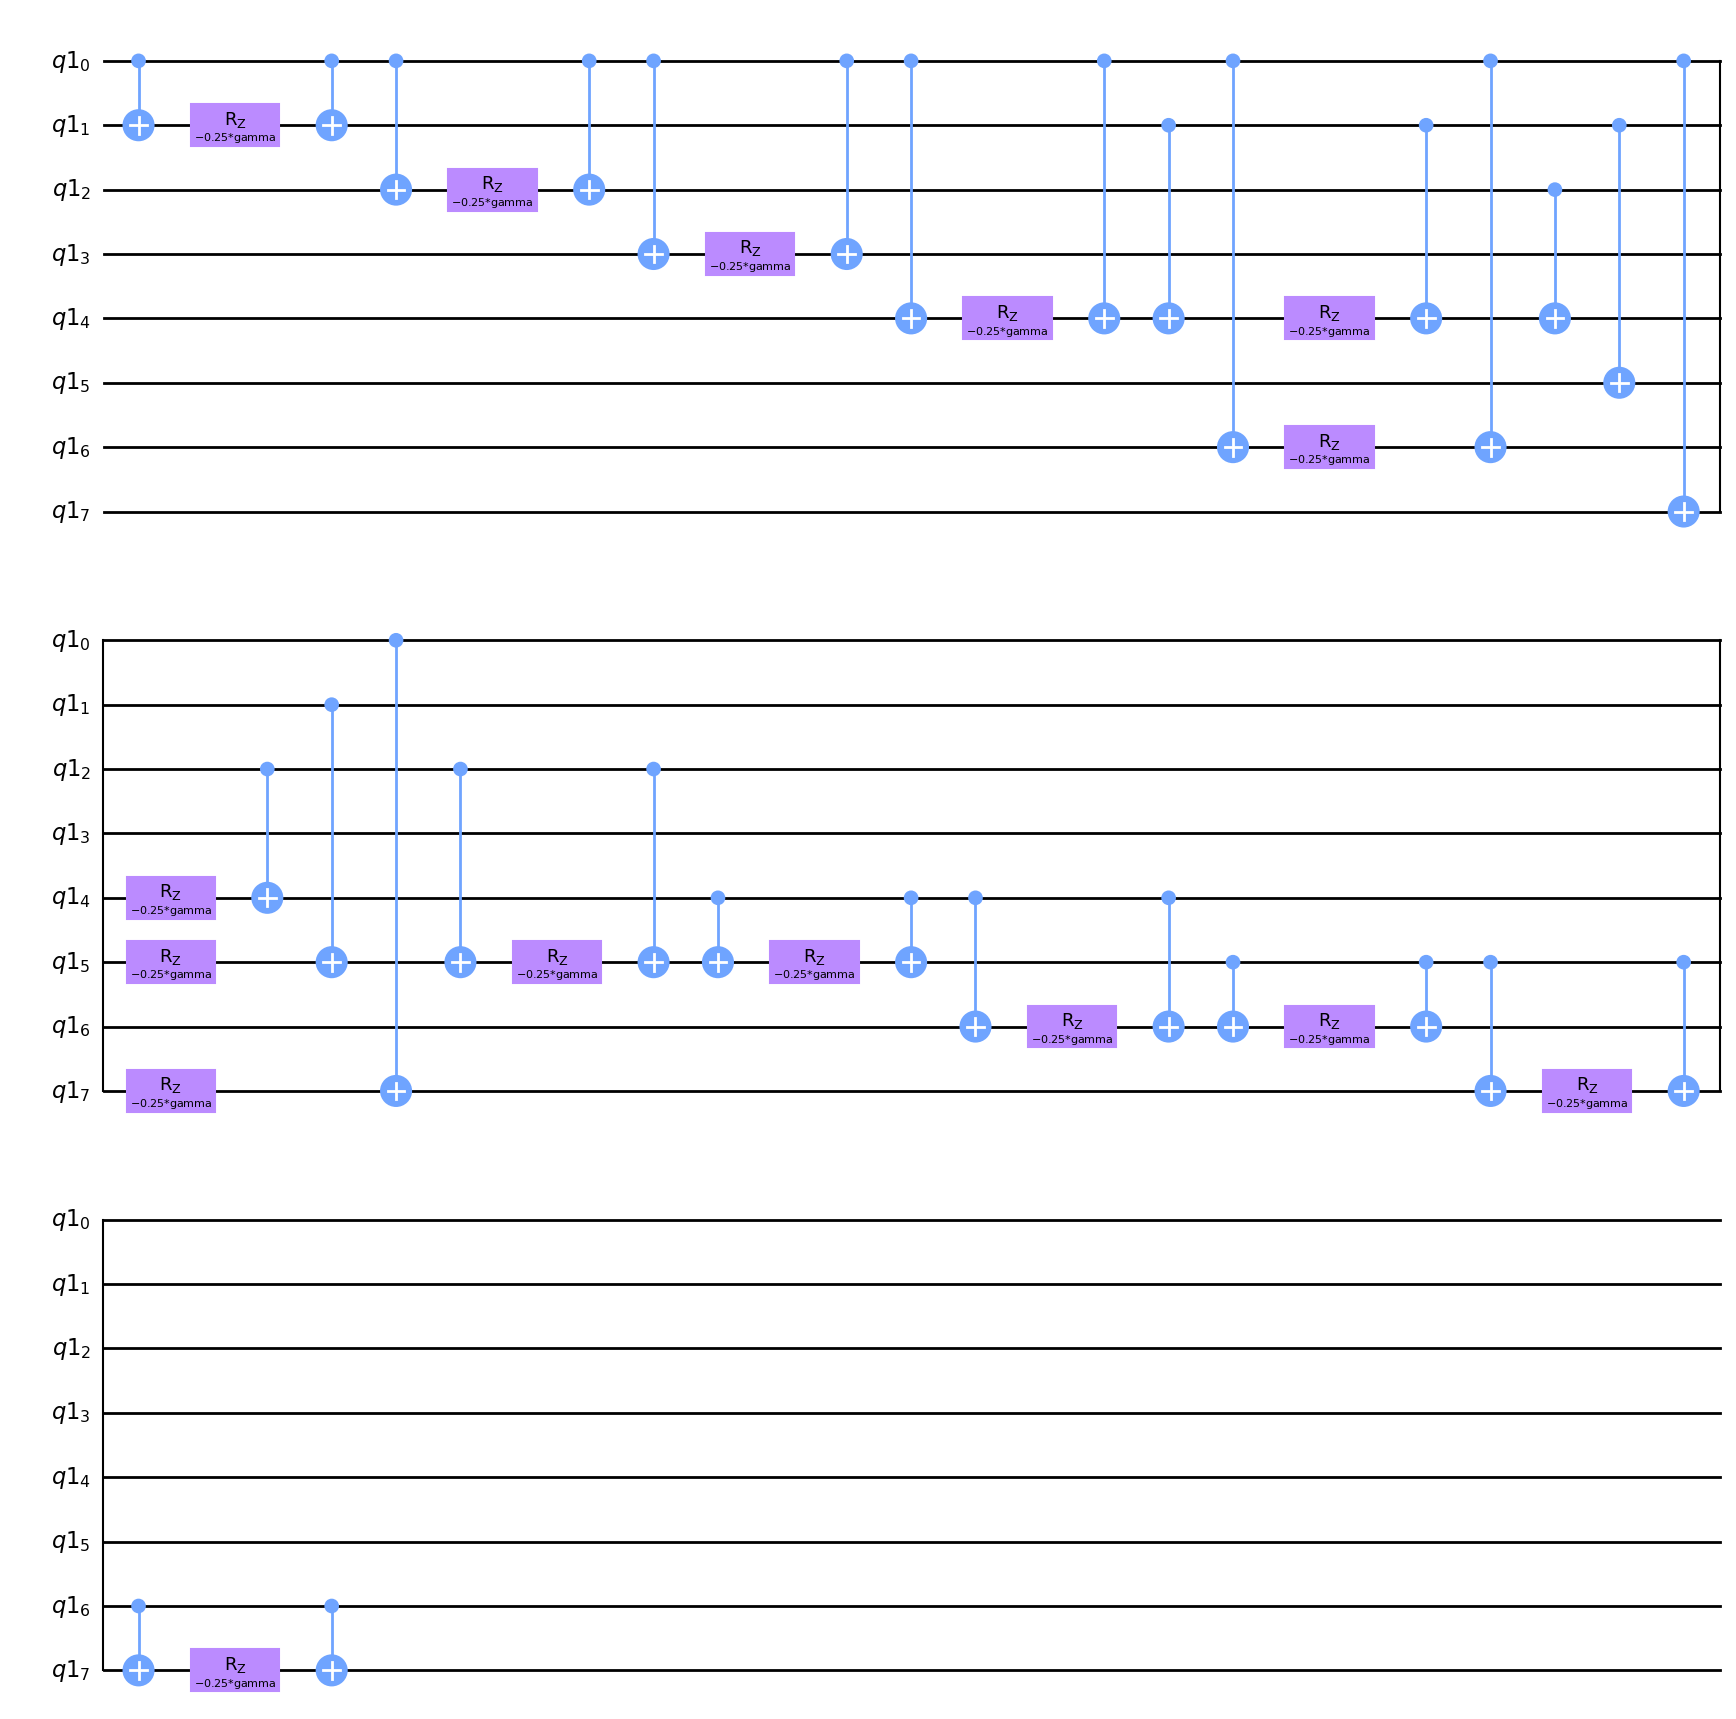

In [9]:
from qiskit.compiler import transpile

transpile(cost_circuit(G), basis_gates=["cx", "rx", "rz"]).draw(output="mpl")

In [10]:
class My_MaxCut(Problem):
    def __init__(self, G) -> None:
        self.G = G
        self.N_qubits = self.G.number_of_nodes()

    def cost(self, string):
        return cost_string(self.G, string)

    def create_circuit(self):
        q = QuantumRegister(self.N_qubits)
        self.circuit = QuantumCircuit(q)
        self.circuit.append(cost_circuit(self.G), q)

In the MAXCUT problem the QAOA minimization is performed with respect to all states, so in particular in the whole n qubits Hilbert Space. For the standard QAOA the the mixing Hamiltonian is $H_{M}=\sum_{i=1}^{N}\sigma^{x}_{i}$ usually called X mixer. So for the Unconstrained QAOA, once we have choose the mixing Hamiltonian, we have to be able to prepare as initial state $\ket{\psi_{0}}$ in the ground state of $H_{M}$  and to be able to implement the mixing operator $U_{M}=e^{-i\beta{H_{M}}}$ in terms of the native gates.

## Exercise: Implement the X mixer operator 

In [11]:
def X_circuit(G):
    N_qubits = G.number_of_nodes()

    qr = QuantumRegister(N_qubits)
    qc = QuantumCircuit(qr, name="Mixer")

    mix_param = Parameter("beta")

    """
    Construct the Quantum circuit that implement the X mixer here
    """

    for i in range(0, N_qubits):
        qc.rx(-mix_param, qr[i])
    return qc

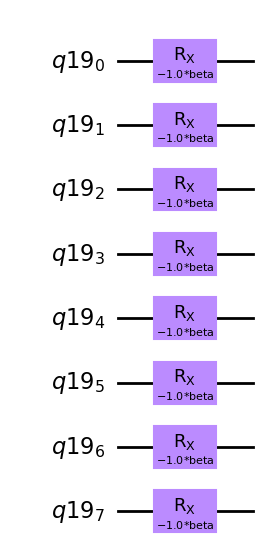

In [12]:
transpile(X_circuit(G), basis_gates=["cx", "rx", "rz", "ry"]).draw(output="mpl")

In [13]:
class My_X(Mixer):
    def __init__(self, G) -> None:
        self.G = G
        self.N_qubits = self.G.number_of_nodes()

    def create_circuit(self):
        q = QuantumRegister(self.N_qubits)

        self.circuit = QuantumCircuit(q)
        self.circuit.append(X_circuit(self.G), q)

## Exercise: Prepare the initial state as the ground state of the Mixing Hamiltonian 

In [14]:
def init_circuit(G):
    N_qubits = G.number_of_nodes()

    qr = QuantumRegister(N_qubits)
    qc = QuantumCircuit(qr, name="initial_state")

    """
    Construct the circuit that prepares the ground state of X mixer
    """

    for i in range(0, N_qubits):
        qc.h(qr[i])
    return qc

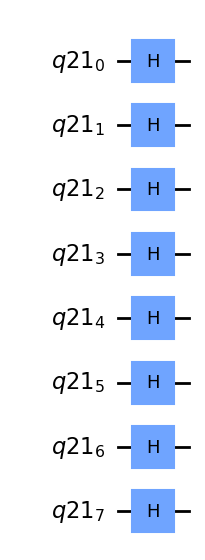

In [15]:
transpile(init_circuit(G), basis_gates=["h", "cx", "rz", "rx", "ry"]).draw(output="mpl")

In [16]:
class My_Initial_circuit(InitialState):
    def __init__(self, G) -> None:
        self.G = G
        self.N_qubits = self.G.number_of_nodes()

    def create_circuit(self):
        q = QuantumRegister(self.N_qubits)
        self.circuit = QuantumCircuit(q)
        self.circuit.append(init_circuit(self.G), q)

Once we have defined the building blocks of our QAOA ansatz we can define an instance using the QAOA package to study the performances of the algorithm

In [17]:
qaoa_x = QAOA(initialstate=My_Initial_circuit(G), problem=My_MaxCut(G=G), mixer=My_X(G=G))

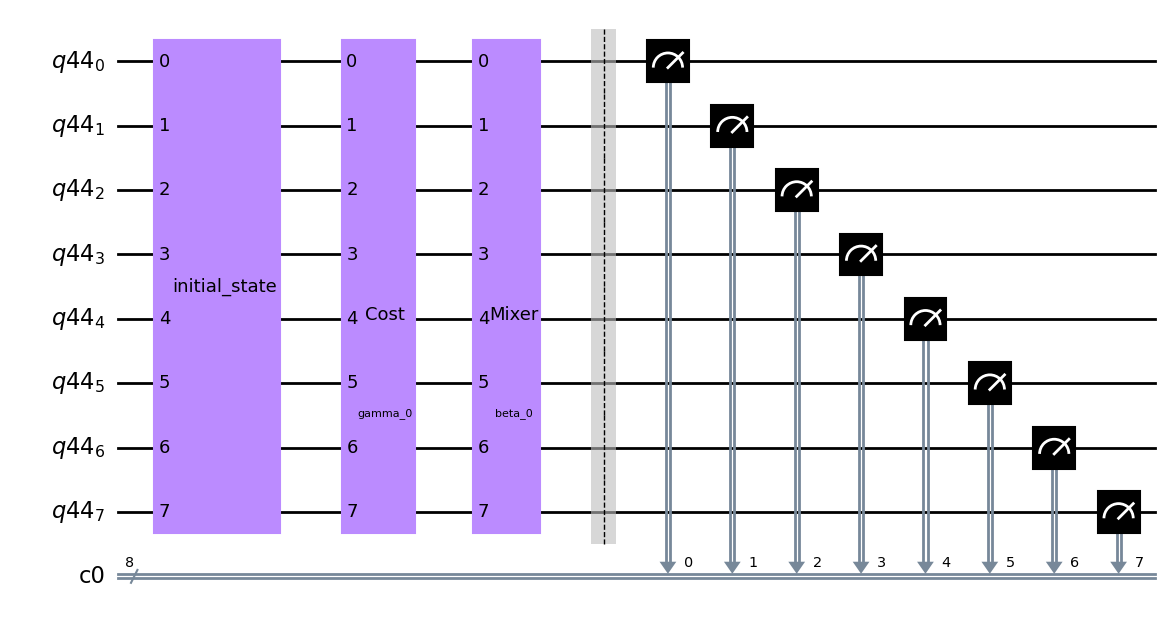

In [18]:
qaoa_x.createParameterizedCircuit(1)
qaoa_x.parameterized_circuit.draw(output="mpl")

In [19]:
min, max = qaoa_x.problem.computeMinMaxCosts()
print(min, max)

-12.0 0


In [20]:
def Hamiltonian_spectrum(G):
    n = len(G.nodes)
    bit_strings = [bin(i)[2:].zfill(n) for i in range(2**n)]
    result = {bit_string: -cost_string(G, bit_string) for bit_string in bit_strings}
    return result

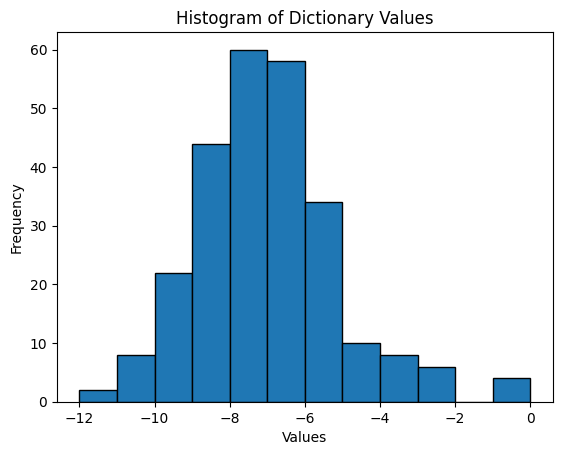

In [21]:
values = list(Hamiltonian_spectrum(G).values())
plt.hist(
    values, bins=np.abs(int(max - min)), edgecolor="black"
)  # Adjust the number of bins as needed
plt.xlabel("Values")
plt.ylabel("Frequency")
plt.title("Histogram of Dictionary Values")
plt.show()

For the case p=1 we can plot how the energy landscape looks like. This can help us to understand better how the optimization routine works. The energy landscape can be obtain just evaluating the energy associated to a certain couples of values $\gamma,\beta$ in a certain range. We know from construction that the energy in periodic in $\beta$ between $[0,2\pi]$ and we want to explore the same range of values for the $\gamma$ parameter.

In the following cell we are going to plot the heatmap related to:

$\bra{\gamma,\beta}H\ket{\gamma,\beta}$, $\gamma,\beta\in[0,2\pi]$

2023-10-26 14:31:10 [info     ] Calculating energy landscape for depth p=1... file=qaoa.qaoa func=sample_cost_landscape
1 0
2023-10-26 14:31:10 [info     ] Executing sample_cost_landscape file=qaoa.qaoa func=sample_cost_landscape
2023-10-26 14:31:10 [info     ] parameters: 2                  file=qaoa.qaoa func=sample_cost_landscape
2023-10-26 14:31:10 [info     ] Done execute                   file=qaoa.qaoa func=sample_cost_landscape
2023-10-26 14:31:14 [info     ] Done measurement               file=qaoa.qaoa func=sample_cost_landscape
2023-10-26 14:31:14 [info     ] Calculating Energy landscape done file=qaoa.qaoa func=sample_cost_landscape


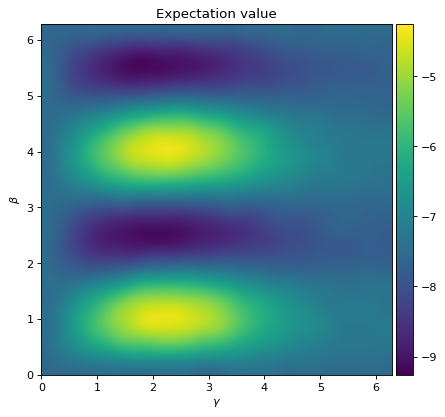

In [22]:
qaoa_x.sample_cost_landscape(
    angles={"gamma": [0, 2 * np.pi, 25], "beta": [0, 2 * np.pi, 25]}
)
plot_E(qaoa_x)

Calling the method optimize we can see how the optimization prodecure perform on the first layer of QAOA and understand from the plot of the landscape how we converge in one local minima

In [23]:
qaoa_x.optimize(depth=1)

2023-10-26 14:31:15 [info     ] cost(depth 1 = -9.2490234375   file=qaoa.qaoa func=optimize


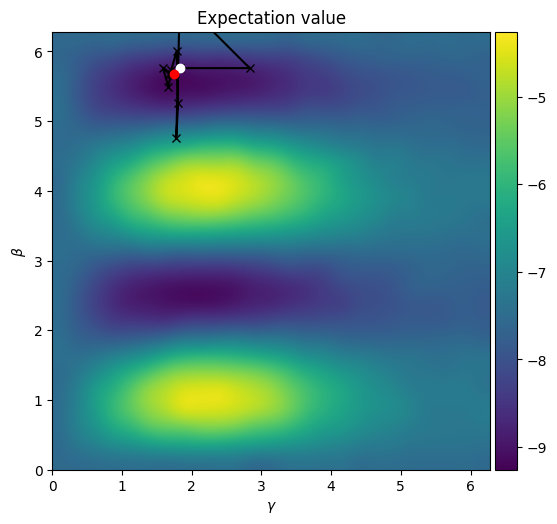

In [24]:
fig = pl.figure(figsize=(6, 6))
gamma = []
beta = []
angles = qaoa_x.optimization_results[1].angles
for i in range(len(angles)):
    gamma.append(angles[i][0])
    beta.append(angles[i][1])
pl.plot(gamma, beta, "x-k")
pl.plot(gamma[0], beta[0], "wo")
pl.plot(gamma[-1], beta[-1], "or")
plot_E(qaoa_x, fig=fig)

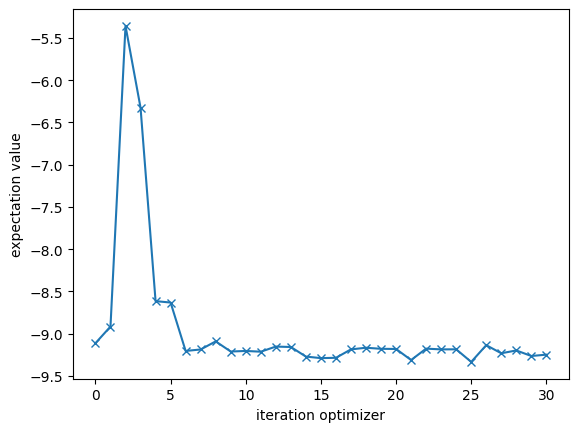

In [25]:
pl.plot(qaoa_x.optimization_results[1].Exp, "x-")
_ = pl.ylabel("expectation value")
_ = pl.xlabel("iteration optimizer")

In [26]:
maxdepth = 6
qaoa_x.optimize(depth=maxdepth)

2023-10-26 14:31:17 [info     ] cost(depth 2 = -9.990234375000004 file=qaoa.qaoa func=optimize
2023-10-26 14:31:21 [info     ] cost(depth 3 = -10.461914062499998 file=qaoa.qaoa func=optimize
2023-10-26 14:31:25 [info     ] cost(depth 4 = -10.940429687500009 file=qaoa.qaoa func=optimize
2023-10-26 14:31:33 [info     ] cost(depth 5 = -11.228515625000005 file=qaoa.qaoa func=optimize
2023-10-26 14:31:42 [info     ] cost(depth 6 = -11.303710937500007 file=qaoa.qaoa func=optimize


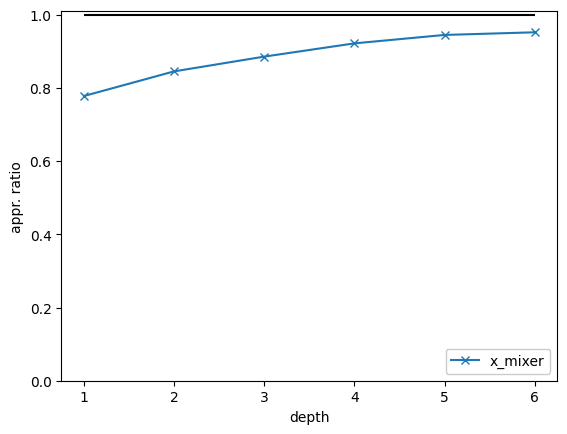

In [27]:
fig = pl.figure()

plot_ApproximationRatio(
    qaoa_x,
    maxdepth,
    mincost=min,
    maxcost=max,
    label="x_mixer",
    style="x-",
    fig=fig,
)

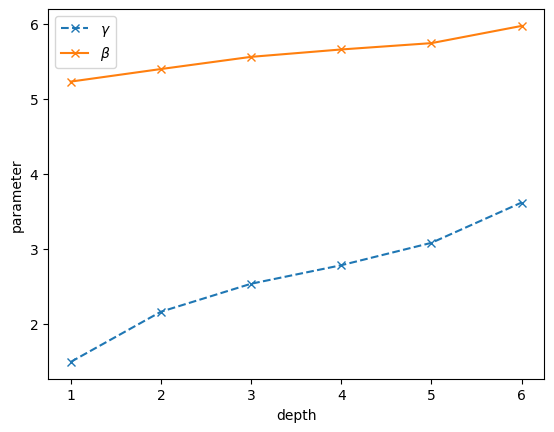

In [28]:
p = maxdepth
fig = pl.figure(p)

plot_angles(qaoa_x, p, label="", style="x", fig=fig)

(0.0, 100.0)

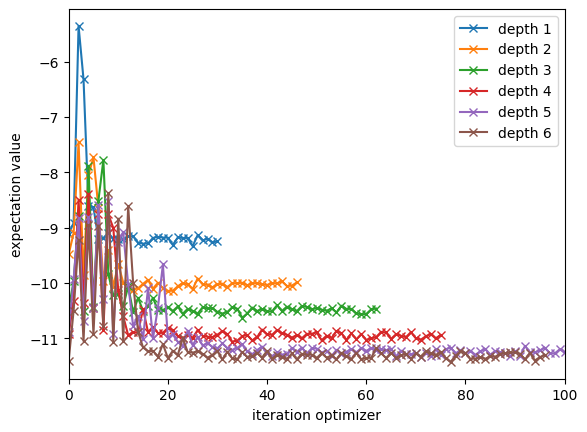

In [29]:
for p in range(maxdepth):
    pl.plot(qaoa_x.optimization_results[p + 1].Exp, "x-", label="depth " + str(p + 1))
_ = pl.ylabel("expectation value")
_ = pl.xlabel("iteration optimizer")
pl.legend()
pl.xlim(0, 100)

## Exercise: Implement the Y Mixer and the new initial state 


We have previously choose as Mixer Hamiltonian $H_{M}=\sum_{i}\sigma_{i}^{x}$ but in principle we could have choosen a different one with the only condition that it has to mix all the possible solutions. 

In this exercise try to explore the perfromance of the QAOA with the Y mixer defined as $H_{M}^{Y}=\sum_{i}\sigma_{i}^{y},\quad \sigma^{y}=\begin{pmatrix}
0 & -i\\ 
i & 0 
\end{pmatrix}$


In [30]:
def Y_circuit(G):
    N_qubits = G.number_of_nodes()

    qr = QuantumRegister(N_qubits)
    qc = QuantumCircuit(qr, name="Y_Mixer")

    mix_param = Parameter("y_beta")

    """
    Construct the Quantum circuit that implement the Y mixer here
    """

    for i in range(0, N_qubits):
        qc.ry(mix_param, qr[i])
    return qc

In [31]:
class My_Y(Mixer):
    def __init__(self, G) -> None:
        self.G = G
        self.N_qubits = self.G.number_of_nodes()

    def create_circuit(self):
        q = QuantumRegister(self.N_qubits)

        self.circuit = QuantumCircuit(q)
        self.circuit.append(Y_circuit(self.G), q)

In [32]:
def Y_init_circuit(G):
    N_qubits = len(G.nodes)

    qr = QuantumRegister(N_qubits)
    qc = QuantumCircuit(qr, name="Y_initial_state")

    """
    Construct the circuit that prepares the ground state of Y mixer
    """

    for i in range(0, N_qubits):
        qc.h(qr[i])
        qc.s(qr[i])
    return qc

In [33]:
class My_Y_Initial_circuit(InitialState):
    def __init__(self, G) -> None:
        self.G = G
        self.N_qubits = self.G.number_of_nodes()

    def create_circuit(self):
        q = QuantumRegister(self.N_qubits)
        self.circuit = QuantumCircuit(q)
        self.circuit.append(Y_init_circuit(self.G), q)

2023-10-26 14:31:42 [info     ] Calculating energy landscape for depth p=1... file=qaoa.qaoa func=sample_cost_landscape
1 0
2023-10-26 14:31:42 [info     ] Executing sample_cost_landscape file=qaoa.qaoa func=sample_cost_landscape
2023-10-26 14:31:42 [info     ] parameters: 2                  file=qaoa.qaoa func=sample_cost_landscape
2023-10-26 14:31:42 [info     ] Done execute                   file=qaoa.qaoa func=sample_cost_landscape
2023-10-26 14:31:46 [info     ] Done measurement               file=qaoa.qaoa func=sample_cost_landscape
2023-10-26 14:31:46 [info     ] Calculating Energy landscape done file=qaoa.qaoa func=sample_cost_landscape


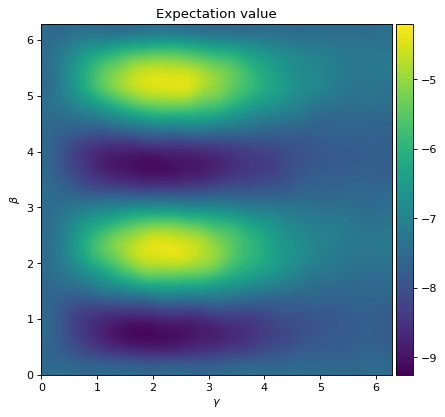

In [34]:
qaoa_y = QAOA(
    initialstate=My_Y_Initial_circuit(G), problem=My_MaxCut(G=G), mixer=My_Y(G=G)
)
qaoa_y.sample_cost_landscape(
    angles={"gamma": [0, 2 * np.pi, 25], "beta": [0, 2 * np.pi, 25]}
)
plot_E(qaoa_y)

2023-10-26 14:31:47 [info     ] cost(depth 1 = -9.180664062499993 file=qaoa.qaoa func=optimize
2023-10-26 14:31:49 [info     ] cost(depth 2 = -10.224609374999998 file=qaoa.qaoa func=optimize
2023-10-26 14:31:52 [info     ] cost(depth 3 = -10.410156250000004 file=qaoa.qaoa func=optimize
2023-10-26 14:31:56 [info     ] cost(depth 4 = -10.850585937500004 file=qaoa.qaoa func=optimize
2023-10-26 14:32:02 [info     ] cost(depth 5 = -11.107421875   file=qaoa.qaoa func=optimize
2023-10-26 14:32:11 [info     ] cost(depth 6 = -11.26953125    file=qaoa.qaoa func=optimize


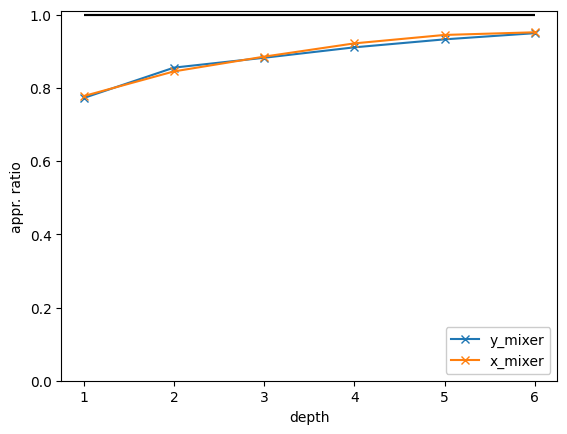

In [35]:
qaoa_y.optimize(depth=maxdepth)
plot_ApproximationRatio(
    qaoa_y,
    maxdepth,
    mincost=min,
    maxcost=max,
    label="y_mixer",
    style="x-",
    fig=fig,
)
plot_ApproximationRatio(
    qaoa_x,
    maxdepth,
    mincost=min,
    maxcost=max,
    label="x_mixer",
    style="x-",
    fig=fig,
)

## Exercise: How the performance change if I choose state Different than the ground state? In this exercise we want to study the performance of the qaoa in function of the overlap with the ground state of the x mixer 

Create a circuit that prepares as initial state $\ket{\psi_{0}(\theta)}=\Pi_{i}^{n}R_{y}^{i}(\theta)\ket{0}=(cos(\frac{\theta}{2})\ket{0}+sin(\frac{\theta}{2})\ket{1})^{\otimes n}$

In [36]:
def Parametric_initial_state_circuit(G, theta):
    N_qubits = G.number_of_nodes()
    qr = QuantumRegister(N_qubits)
    qc = QuantumCircuit(qr, name="Y_initial_state")

    """
    Construct the circuit that prepares the initial state in function of theta
    """

    for i in range(0, N_qubits):
        qc.ry(theta, qr[i])
    return qc

In [37]:
class My_parametric_Initial_circuit(InitialState):
    def __init__(self, G, theta) -> None:
        self.G = G
        self.N_qubits = self.G.number_of_nodes()
        self.theta = theta

    def create_circuit(self):
        q = QuantumRegister(self.N_qubits)
        self.circuit = QuantumCircuit(q)
        self.circuit.append(Parametric_initial_state_circuit(self.G, self.theta), q)

Construct a function that evaluates the overlap between this new initial state and the ground state of the X mixer depending of $\theta$ 

$f(\theta)=|\langle \psi_{0}(\theta)| +\rangle^{\otimes n}|^{2}$

In [38]:
def Overlap_ground_state(G, theta):
    Num_qubits = G.number_of_nodes()
    f = 0
    f = np.abs((1 + np.sin(theta)) / 2) ** Num_qubits
    return f

Compute now the performance of the QAOA with depth 1 using different 6 theta values in the range $[0,\pi]$

In [39]:
k = 10  # number_of_points
thetas = np.linspace(0, np.pi / 2, k)
overlaps = []
qaoa = []

for theta in thetas:
    qaoa.append(
        QAOA(
            initialstate=My_parametric_Initial_circuit(G, theta),
            problem=My_MaxCut(G=G),
            mixer=My_X(G=G),
        )
    )
    overlaps.append(Overlap_ground_state(G, theta))

print(thetas)
print(overlaps)

for i in range(k):
    qaoa[i].sample_cost_landscape(
        angles={"gamma": [0, 2 * np.pi, 10], "beta": [0, 2 * np.pi, 10]}
    )
    qaoa[i].optimize(depth=1)

[0.         0.17453293 0.34906585 0.52359878 0.6981317  0.87266463
 1.04719755 1.22173048 1.3962634  1.57079633]
[0.00390625, 0.014062530094128077, 0.04109909991709365, 0.1001129150390625, 0.20721032112809412, 0.3696349796708132, 0.5742492671726727, 0.7827504816417608, 0.9408223292180032, 1.0]
2023-10-26 14:32:11 [info     ] Calculating energy landscape for depth p=1... file=qaoa.qaoa func=sample_cost_landscape
1 0
2023-10-26 14:32:11 [info     ] Executing sample_cost_landscape file=qaoa.qaoa func=sample_cost_landscape
2023-10-26 14:32:11 [info     ] parameters: 2                  file=qaoa.qaoa func=sample_cost_landscape
2023-10-26 14:32:11

 [info     ] Done execute                   file=qaoa.qaoa func=sample_cost_landscape
2023-10-26 14:32:11 [info     ] Done measurement               file=qaoa.qaoa func=sample_cost_landscape
2023-10-26 14:32:11 [info     ] Calculating Energy landscape done file=qaoa.qaoa func=sample_cost_landscape
2023-10-26 14:32:12 [info     ] cost(depth 1 = -7.4062499999999964 file=qaoa.qaoa func=optimize
2023-10-26 14:32:12 [info     ] Calculating energy landscape for depth p=1... file=qaoa.qaoa func=sample_cost_landscape
1 0
2023-10-26 14:32:12 [info     ] Executing sample_cost_landscape file=qaoa.qaoa func=sample_cost_landscape
2023-10-26 14:32:12 [info     ] parameters: 2                  file=qaoa.qaoa func=sample_cost_landscape
2023-10-26 14:32:12 [info     ] Done execute                   file=qaoa.qaoa func=sample_cost_landscape
2023-10-26 14:32:13 [info     ] Done measurement               file=qaoa.qaoa func=sample_cost_landscape
2023-10-26 14:32:13 [info     ] Calculating Energy landscape

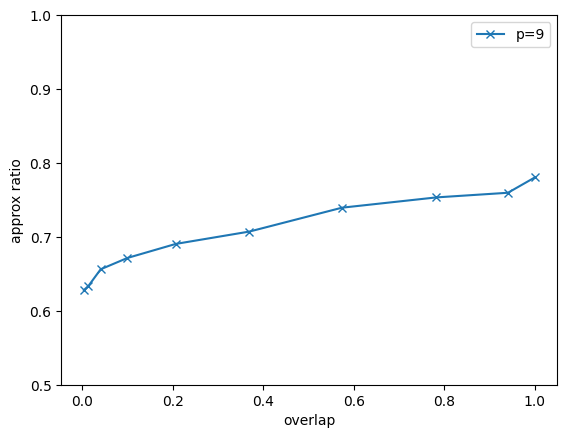

In [40]:
exp = []
for j in range(k):
    exp.append((np.min(qaoa[j].optimization_results[1].Exp) - max) / (min - max))
plt.plot(overlaps, exp, label="p=" + str(i), marker="x")

plt.xlabel("overlap")
plt.ylabel("approx ratio")
_ = plt.legend()
_ = plt.ylim([0.5, 1])

## Exercise: Use the Symmetry of the Problem to reduce the number of qubits necessary 

The Maxcut problem exhibits inherent symmetry concerning the flexibility of relabeling partitions. One approach is to assign the value 0 to a node in set A and 1 if it belongs to set B, or vice versa. This interchange does not alter the cost function associated with the partition. Therefore, we can deduce that the cost function remains invariant when the entire string is flipped.

$C(x)=\sum_{ij}w_{ij}x_{i}(1-x_{j})=\sum_{ij}w_{ij}(1-x_{i})x_{j}$

This symmetry is of course has to be reflected in the quantum problem Hamiltonian 

$H_{P}=\sum_{ij}w_{ij}\sigma_{i}^{z}\sigma_{j}^{z}$

and it can be expressed considering the same symmetry: if I flip all the spins the energy cost should remain the same.

The flip operator can be expressed as: $M=\otimes_{i} \sigma_{i}^{x}$ 

$MH_{P}M=H_{P}$


Can you use this symmetry to reduce the dimension of the problem?

In [41]:
def reduced_cost_string(G, string):
    """
    Construct here the function that takes in input the reduced string and output the cost associated to the graph G
    """

    string = "0" + string
    C = cost_string(G, string)

    return C


def reduced_cost_circuit(G):
    N_qubits = G.number_of_nodes() - 1
    print(N_qubits)
    qr = QuantumRegister(N_qubits)
    qc = QuantumCircuit(qr, name="Cost")
    cost_param = Parameter("gamma")
    """
    Construct Here the function that takes in input the problem graph G and returns as output the circuit 
    corresponding to the exponential of the reduced cost function.
    """

    for edge in G.edges():
        i = int(edge[0])
        j = int(edge[1])

        w = G[edge[0]][edge[1]]["weight"]
        wg = -w * cost_param / 4
        if i != 0 and j != 0:
            qc.append(ZZGate(wg), [qr[i - 1], qr[j - 1]])

        else:
            if i == 0:
                qc.rz(wg, qr[j - 1])
            else:
                qc.rz(wg, qr[i - 1])

    return qc

In [42]:
class Reduced_MaxCut(Problem):
    def __init__(self, G) -> None:
        self.G = G
        self.N_qubits = self.G.number_of_nodes() - 1

    def cost(self, string):
        return reduced_cost_string(self.G, string)

    def create_circuit(self):
        q = QuantumRegister(self.N_qubits)
        self.circuit = QuantumCircuit(q)
        self.circuit.append(reduced_cost_circuit(self.G), q)

In [43]:
def Reduced_X_mixer(G):
    N_qubits = G.number_of_nodes() - 1

    qr = QuantumRegister(N_qubits)
    qc = QuantumCircuit(qr, name="reduced_Mixer")

    mix_param = Parameter("beta")

    """
    Construct the Quantum circuit that implement the X mixer for the reduced problem here
    """
    for i in range(0, N_qubits):
        qc.rx(-mix_param, qr[i])

    return qc

In [44]:
class Reduced_X(Mixer):
    def __init__(self, G) -> None:
        self.G = G
        self.N_qubits = self.G.number_of_nodes()

    def create_circuit(self):
        q = QuantumRegister(self.N_qubits)

        self.circuit = QuantumCircuit(q)
        self.circuit.append(Reduced_X_mixer(self.G), q)

In [45]:
def Reduced_initial_state_circuit(G):
    N_qubits = G.number_of_nodes() - 1

    qr = QuantumRegister(N_qubits)
    qc = QuantumCircuit(qr, name="Y_initial_state")

    """
    Construct the circuit that prepares the ground state of X mixer for the reduced problem Here
    """

    for i in range(0, N_qubits):
        qc.h(qr[i])
    return qc

In [46]:
class Reduced_Initial_circuit(InitialState):
    def __init__(self, G) -> None:
        self.G = G
        self.N_qubits = self.G.number_of_nodes()

    def create_circuit(self):
        q = QuantumRegister(self.N_qubits)
        self.circuit = QuantumCircuit(q)
        self.circuit.append(Reduced_initial_state_circuit(self.G), q)

In [47]:
reduced_qaoa = QAOA(
    initialstate=Reduced_Initial_circuit(G),
    problem=Reduced_MaxCut(G=G),
    mixer=Reduced_X(G=G),
)

7


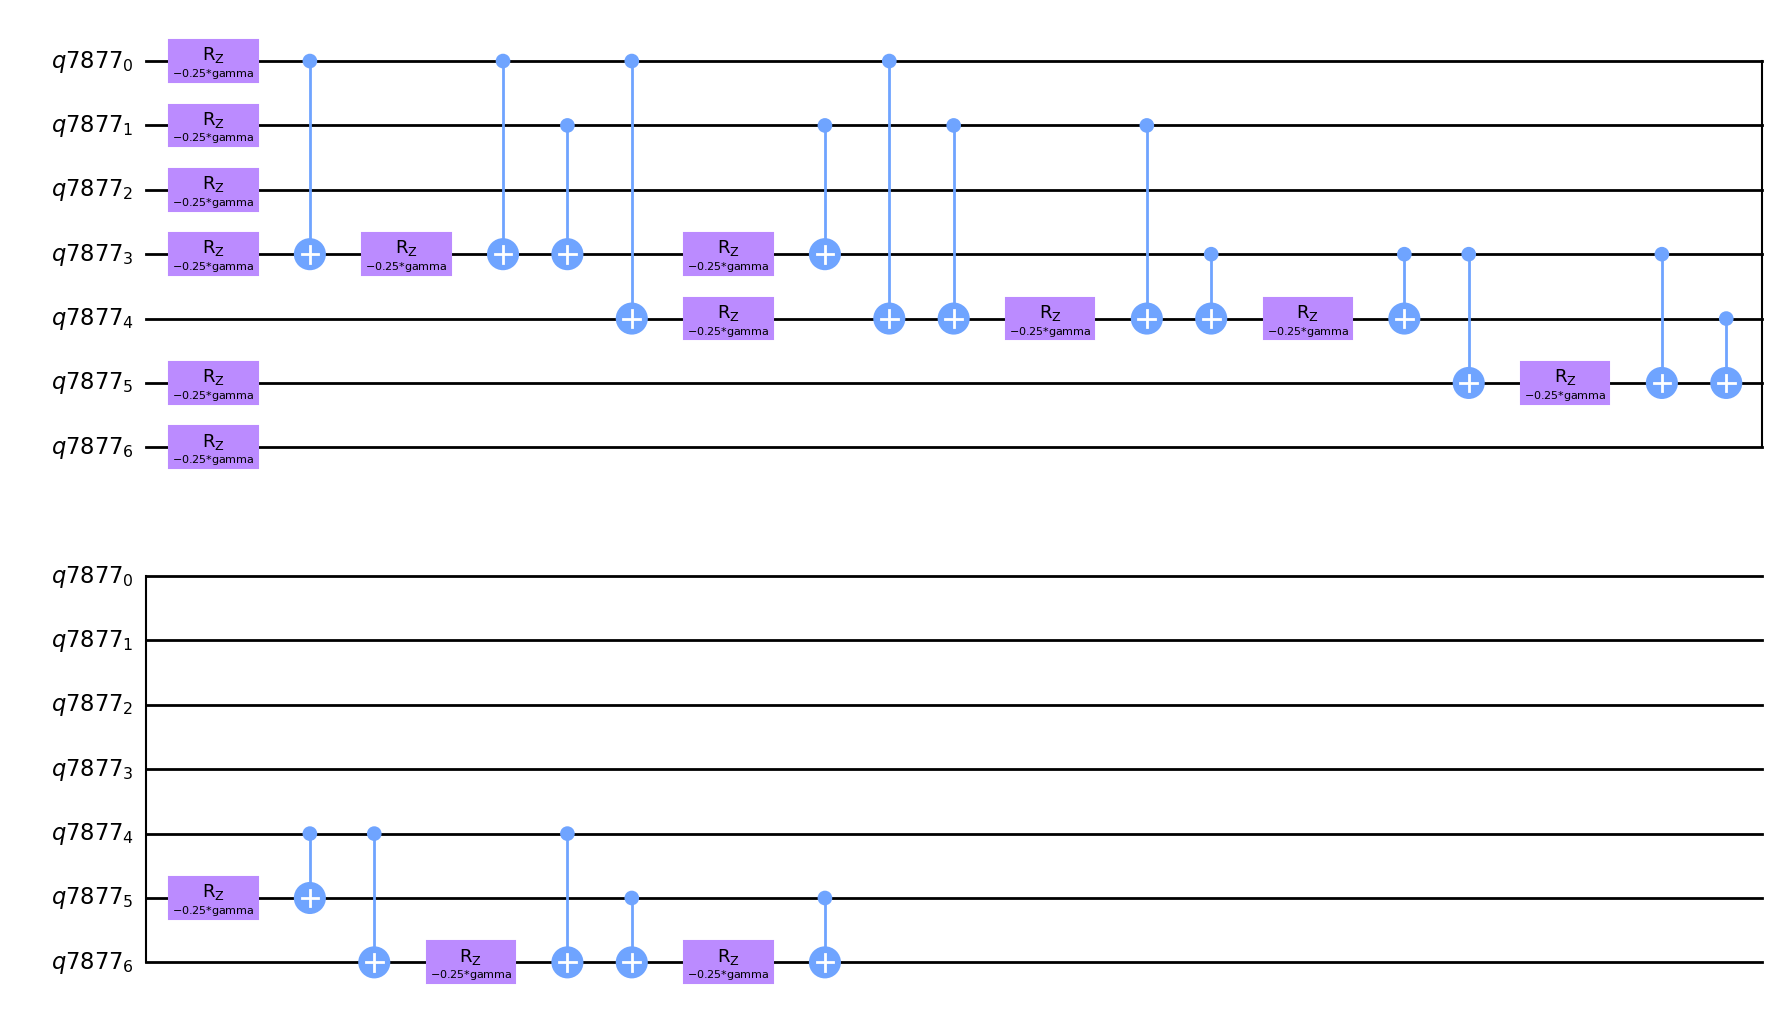

In [49]:
from qiskit.compiler import transpile

transpile(reduced_cost_circuit(G), basis_gates=["cx", "rx", "rz"]).draw(output="mpl")

2023-10-26 14:32:25 [info     ] Calculating energy landscape for depth p=1... file=qaoa.qaoa func=sample_cost_landscape
1 0
7
2023-10-26 14:32:25 [info     ] Executing sample_cost_landscape file=qaoa.qaoa func=sample_cost_landscape
2023-10-26 14:32:25 [info     ] parameters: 2                  file=qaoa.qaoa func=sample_cost_landscape
2023-10-26 14:32:25 [info     ] Done execute                   file=qaoa.qaoa func=sample_cost_landscape
2023-10-26 14:32:29 [info     ] Done measurement               file=qaoa.qaoa func=sample_cost_landscape
2023-10-26 14:32:29 [info     ] Calculating Energy landscape done file=qaoa.qaoa func=sample_cost_landscape


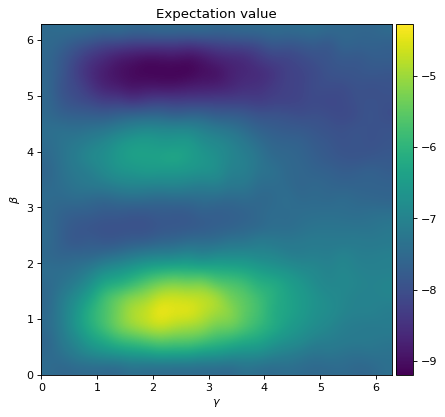

In [50]:
reduced_qaoa.sample_cost_landscape(
    angles={"gamma": [0, 2 * np.pi, 25], "beta": [0, 2 * np.pi, 25]}
)
plot_E(reduced_qaoa)

Now Compare the result obtained with the initial MaxCut problem and the reduced one and verify that the find the same solution

In [51]:
reduced_qaoa.optimize(maxdepth)

7
2023-10-26 14:32:29 [info     ] cost(depth 1 = -9.179687499999995 file=qaoa.qaoa func=optimize
7
2023-10-26 14:32:30 [info     ] cost(depth 2 = -9.893554687499998 file=qaoa.qaoa func=optimize
7
2023-10-26 14:32:33 [info     ] cost(depth 3 = -10.702148437500004 file=qaoa.qaoa func=optimize
7
2023-10-26 14:32:37 [info     ] cost(depth 4 = -10.755859375000005 file=qaoa.qaoa func=optimize
7
2023-10-26 14:32:42 [info     ] cost(depth 5 = -11.012695312500005 file=qaoa.qaoa func=optimize
7
2023-10-26 14:32:49 [info     ] cost(depth 6 = -11.1337890625  file=qaoa.qaoa func=optimize


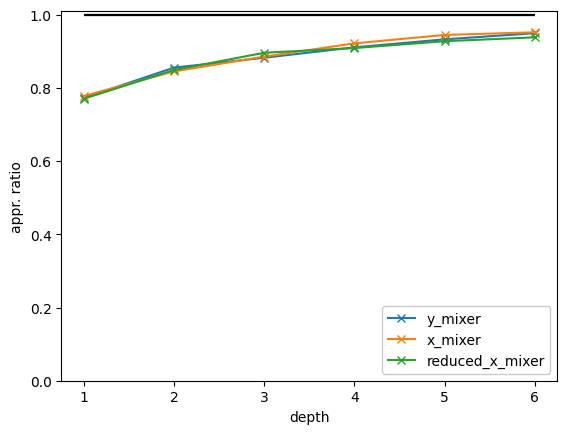

In [52]:
plot_ApproximationRatio(
    qaoa_y,
    maxdepth,
    mincost=min,
    maxcost=max,
    label="y_mixer",
    style="x-",
    fig=fig,
)
plot_ApproximationRatio(
    qaoa_x,
    maxdepth,
    mincost=min,
    maxcost=max,
    label="x_mixer",
    style="x-",
    fig=fig,
)
plot_ApproximationRatio(
    reduced_qaoa,
    maxdepth,
    mincost=min,
    maxcost=max,
    label="reduced_x_mixer",
    style="x-",
    fig=fig,
)